In [8]:
import numpy as np
import networkx as nx
import gurobipy as gp
import dimod as dm
import matplotlib.pyplot as plt
import time as tm

In [9]:
np.random.seed(10)
n = 5
H = nx.complete_graph(n)
pos = {v:(100*np.random.rand(),100*np.random.rand()) for v in H.nodes()}

for e in H.edges(data=True):
    H[e[0]][e[1]]['length'] = round(((pos[e[0]][0]-pos[e[1]][0])**2 + (pos[e[0]][1]-pos[e[1]][1])**2)**0.5)


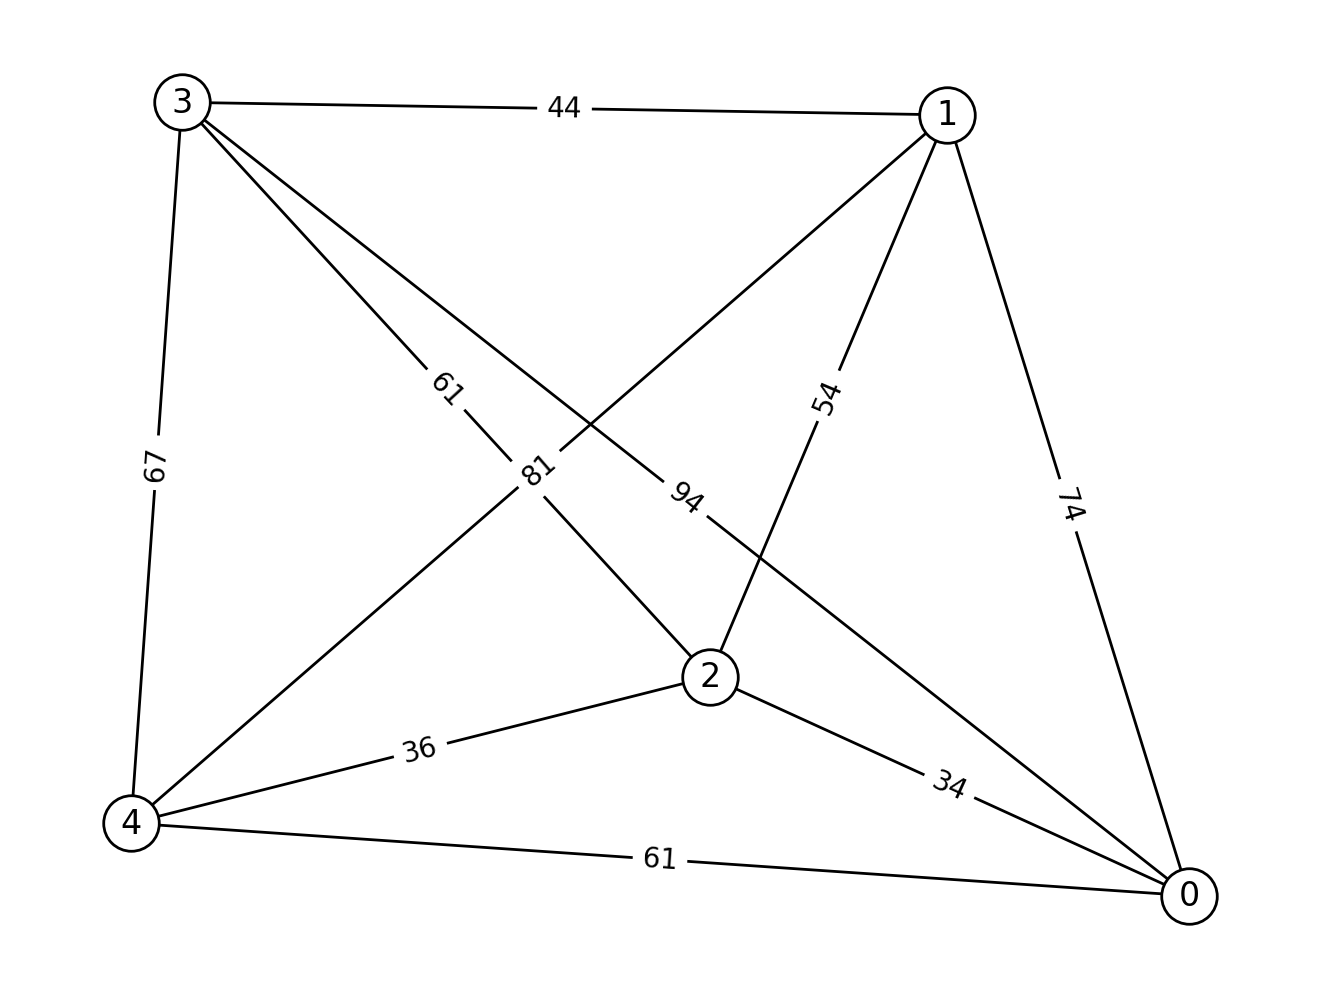

In [10]:
plt.figure(dpi=200)
labels = {v:str(v) for v in H.nodes}
nx.draw(H,pos=pos,labels=labels,node_size=400, node_color = 'w',edgecolors='k')
elabels = nx.get_edge_attributes(H, 'length') 
l = nx.draw_networkx_edge_labels(H, pos, edge_labels = elabels)

Optimal tour length:	 255.0
Runtime:		 15.96


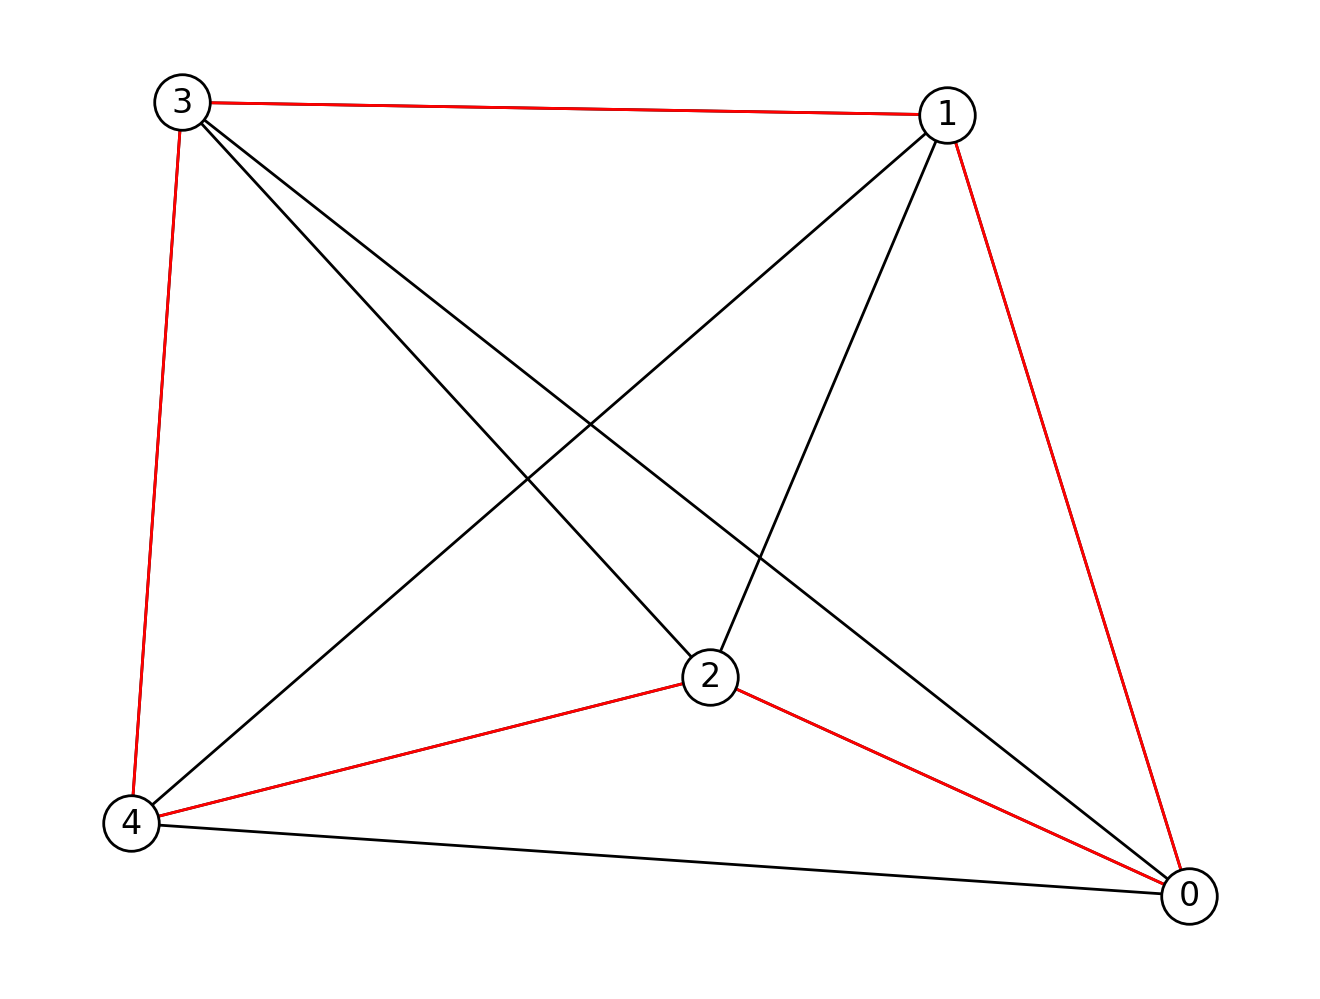

In [11]:
qubomodel = gp.Model()
Hd = nx.DiGraph(H)
xq = {}
V = [v for v in H.nodes() if v != 0]
m = H.number_of_nodes() - 1
for j in range(m):
    for v in V:
            xq[v,j] = qubomodel.addVar(vtype='b',name=f'x_{v}_{j}')
A = max(nx.get_edge_attributes(H, 'length').values() ) + 1
B = 1
qubomodel.update()
qubomodel.setObjective(
    A*gp.quicksum((1-gp.quicksum(xq[v,j] for v in V))**2 for j in range(m)) +
    A*gp.quicksum((1-gp.quicksum(xq[v,j] for j in range(m)))**2 for v in V) +
    
    B*gp.quicksum(H[u][v]['length']*(gp.quicksum(xq[u,j]*xq[v,j+1] for j in range(m-1))) for u,v in Hd.edges() if u in V and v in V) +
    B*gp.quicksum(H[0][u]['length']*xq[u,0] for u in H.neighbors(0)) +
    B*gp.quicksum(H[0][u]['length']*xq[u,m-1] for u in H.neighbors(0)) )
qubomodel.update()
qubomodel.params.OutPutFlag = 0
qubomodel.params.TimeLimit = 30

qubomodel.optimize()
print('Optimal tour length:\t', qubomodel.ObjVal)
print('Runtime:\t\t', round(qubomodel.Runtime*1000,2))
edgelist = []
lastnode = 0
plt.figure(dpi=200)
labels = {v:str(v) for v in H.nodes}
nx.draw(H,pos=pos,labels=labels,node_size=400, node_color = 'w',edgecolors='k')
for j in range(m):
    for v in V:
        if xq[v,j].X > 0.5:
                node = v
                edgelist.append((lastnode,node))
                lastnode = node
edgelist.append((lastnode,0))
p = nx.draw_networkx_edges(H, pos,edgelist,edge_color='r')

In [12]:
xd = {}
V = [v for v in Hd.nodes() if v != 0]
for j in range(m):
    for v in V:
            xd[v,j] = dm.BinaryQuadraticModel({f'x_{v}_{j}':1},{},0,vartype='BINARY')
HA = (dm.quicksum((1-dm.quicksum(xd[v,j] for v in V))**2 for j in range(m)) +
      dm.quicksum((1-dm.quicksum(xd[v,j] for j in range(m)))**2 for v in V) 
     )
HB = (
      dm.quicksum(Hd[u][v]['length']*(dm.quicksum(xd[u,j]*xd[v,j+1] for j in range(m-1))) for u,v in Hd.edges() if u in V and v in V) +
      dm.quicksum(Hd[0][u]['length']*xd[u,0] for u in Hd.neighbors(0)) +
      dm.quicksum(Hd[0][u]['length']*xd[u,m-1] for u in Hd.neighbors(0)))
bqm = A*HA + B*HB
bqm = dm.BinaryQuadraticModel(bqm.linear, {interaction: bias for interaction, bias in bqm.quadratic.items() if bias}, bqm.offset, bqm.vartype())

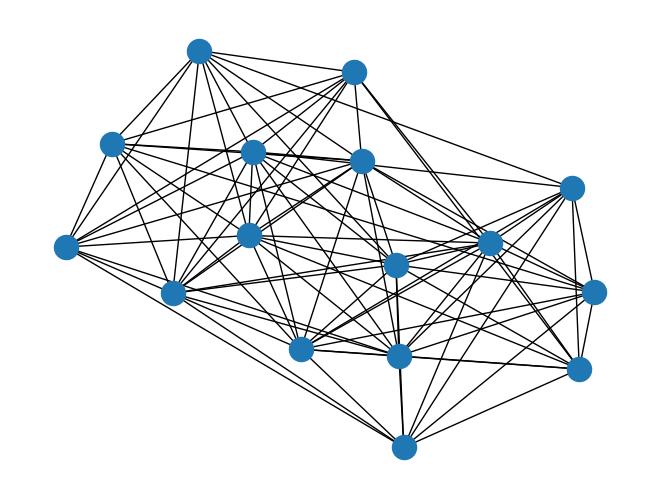

In [13]:
nx.draw(dm.to_networkx_graph(bqm))

In [14]:
from dwave.system import DWaveSampler, LazyFixedEmbeddingComposite, AutoEmbeddingComposite
# sampler = dm.ExactSolver()
# sample = sampler.sample(bqm)
sampler_fixed_embedding = AutoEmbeddingComposite(DWaveSampler(profile='defaults'))

In [15]:
StartTime = tm.time()
sample = sampler_fixed_embedding.sample(bqm,
                                        num_reads=1000,
                                        annealing_time = 20,
                                        label="tiny_tsp_at20_nr1000")
ElapsedTime = tm.time() - StartTime
print('Total time:\t',round(ElapsedTime*1000,2))
print('QPU time:\t',round(sample.info['timing']['qpu_access_time']/1e3,2))

Total time:	 220.57
QPU time:	 160.32


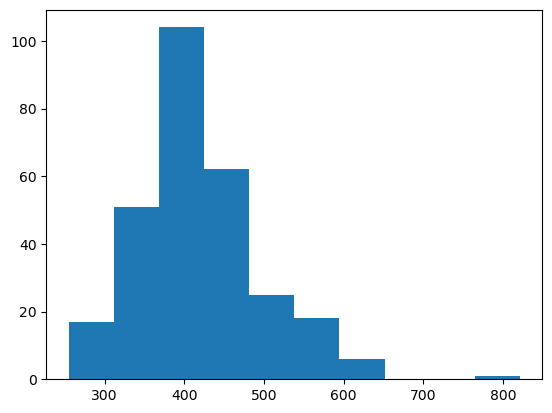

In [16]:
energies = []
for s in sample.data():
    energies.append(s.energy)
h = plt.hist(energies,bins=None,edgecolor = None,fill=True,label='1000 shots, 1 microsec. at')

255.0


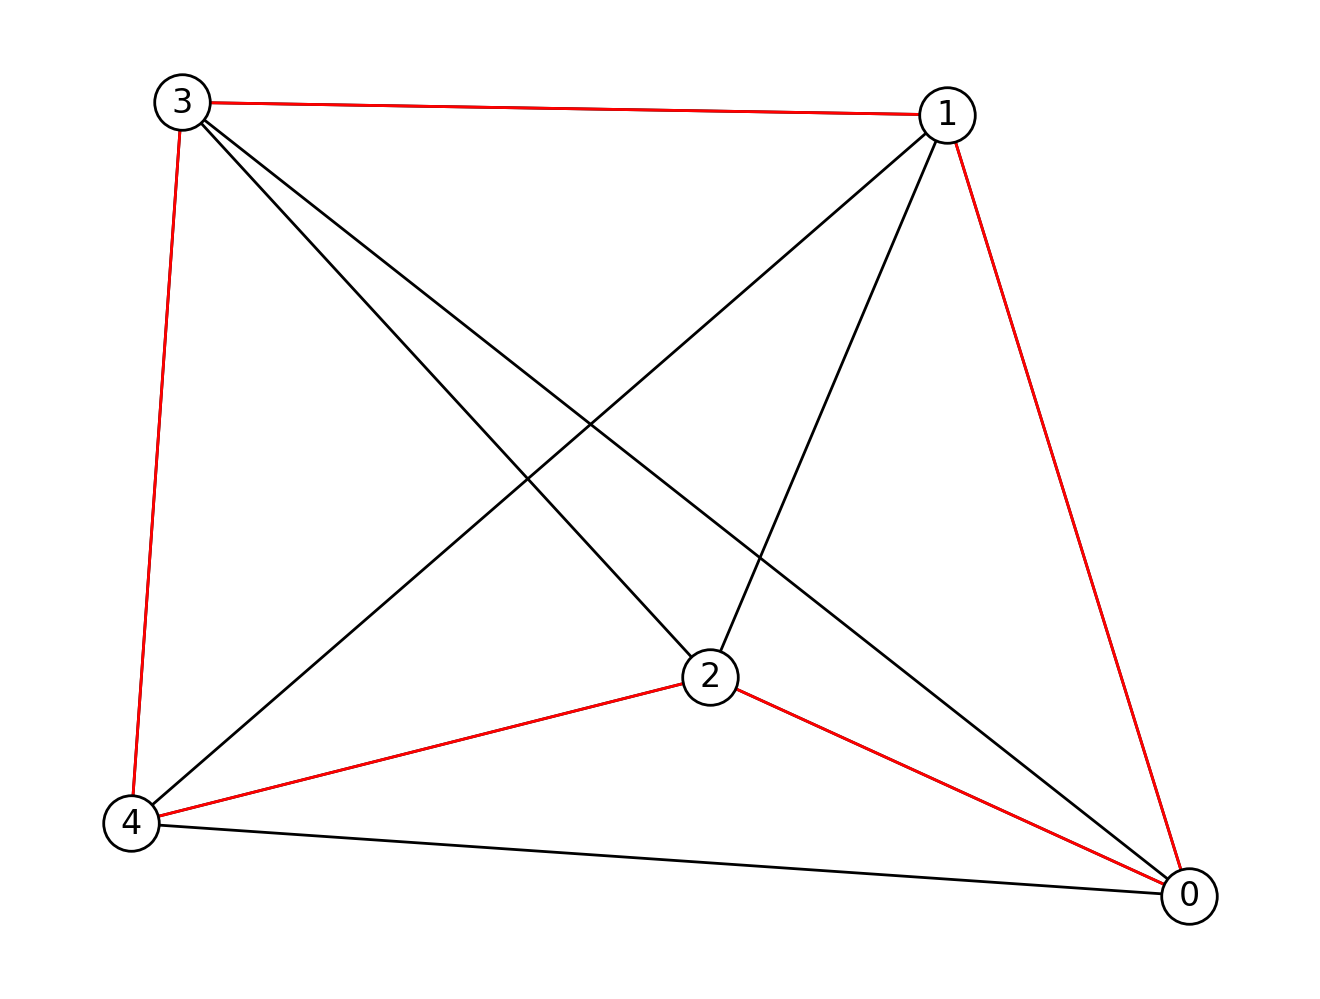

In [17]:
bestsample = sample.lowest().first
print(bestsample.energy)
edgelist = []
lastnode = 0
plt.figure(dpi=200)
labels = {v:str(v) for v in H.nodes}
nx.draw(H,pos=pos,labels=labels,node_size=400, node_color = 'w',edgecolors='k')
for j in range(m):
    for v in V:
        if bestsample.sample[f'x_{v}_{j}'] > 0.5:
                node = v
                edgelist.append((lastnode,node))
                lastnode = node
edgelist.append((lastnode,0))
e = nx.draw_networkx_edges(H, pos,edgelist,edge_color='r')

In [66]:
bestsample.sample

{'x_1_0': 0,
 'x_1_1': 1,
 'x_1_2': 0,
 'x_2_0': 0,
 'x_2_1': 0,
 'x_2_2': 1,
 'x_3_0': 1,
 'x_3_1': 0,
 'x_3_2': 0}